## POS tagging using modified Viterbi

### Data Preparation

In [58]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
nltk.download('universal_tagset')


import warnings
warnings.filterwarnings('ignore')
# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)



sns.set_style(style='dark')
sns.set_context("notebook")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/akumar/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [59]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [60]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

## Configuration

In [61]:
random_state=100
small_sample = True

In [62]:
train_set, test_set = train_test_split(nltk_data,test_size=0.05,random_state=random_state)

In [63]:
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95949

In [64]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['One',
 'bright',
 'sign',
 'is',
 'that',
 'a',
 'growing',
 'number',
 'of',
 'women']

In [65]:
# vocabulary
V = set(tokens)
print(len(V))

12106


In [66]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [67]:
print(T)

{'NUM', 'PRON', 'ADP', 'ADV', 'PRT', 'DET', 'X', 'CONJ', 'VERB', 'NOUN', 'ADJ', '.'}


## Emission Probabilities

In [68]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [69]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag=train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

In [70]:
# Example will
print("\n", "have")
print(word_given_tag('have', 'PRON'))
print(word_given_tag('have', 'NOUN'))
print(word_given_tag('have', 'VERB'))


 have
(0, 2610)
(0, 27539)
(305, 12919)


## Transition Probabilities

In [71]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag=train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t == t1])
    count_t2_t1 = 0
    for index in range(len(tags) - 1):
        if tags[index] == t1 and tags[index + 1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [72]:
# examples
print(t2_given_t1(t2='VERB', t1='NOUN'))
print(t2_given_t1('NOUN', 'ADJ'))

(4047, 27539)
(4279, 6105)


In [73]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('ADJ', '.'))

(2481, 11149)
(989, 11149)
(487, 11149)


In [74]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)):
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0] / t2_given_t1(t2, t1)[1]

In [75]:
tags_matrix

array([[1.84194893e-01, 1.48544263e-03, 3.50564457e-02, 2.67379684e-03,
        2.61437912e-02, 3.86215094e-03, 2.11824119e-01, 1.30718956e-02,
        1.69340465e-02, 3.52346987e-01, 3.35710049e-02, 1.18835412e-01],
       [7.27969361e-03, 7.66283507e-03, 2.33716480e-02, 3.40996161e-02,
        1.22605367e-02, 9.19540226e-03, 9.27203074e-02, 4.98084305e-03,
        4.84291196e-01, 2.11494252e-01, 7.20306486e-02, 4.06130254e-02],
       [6.19103163e-02, 6.91190511e-02, 1.74917839e-02, 1.33573627e-02,
        1.48415135e-03, 3.23969036e-01, 3.49835679e-02, 8.48086493e-04,
        8.48086551e-03, 3.21212769e-01, 1.07388951e-01, 3.97540554e-02],
       [3.16244997e-02, 1.56458057e-02, 1.19507320e-01, 7.72303566e-02,
        1.43142473e-02, 6.99067935e-02, 2.33022645e-02, 6.99067907e-03,
        3.44540626e-01, 3.16244997e-02, 1.30159780e-01, 1.35153130e-01],
       [5.61023615e-02, 1.77165363e-02, 1.93569548e-02, 1.01706041e-02,
        1.96850393e-03, 1.01049870e-01, 1.31233595e-02, 2.29

In [76]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [77]:
tags_df

,NUM,PRON,ADP,ADV,PRT,DET,X,CONJ,VERB,NOUN,ADJ,.
NUM,0.1842,0.0015,0.0351,0.0027,0.0261,0.0039,0.2118,0.0131,0.0169,0.3523,0.0336,0.1188
PRON,0.0073,0.0077,0.0234,0.0341,0.0123,0.0092,0.0927,0.0050,0.4843,0.2115,0.0720,0.0406
ADP,0.0619,0.0691,0.0175,0.0134,0.0015,0.3240,0.0350,0.0008,0.0085,0.3212,0.1074,0.0398
ADV,0.0316,0.0156,0.1195,0.0772,0.0143,0.0699,0.0233,0.0070,0.3445,0.0316,0.1302,0.1352
PRT,0.0561,0.0177,0.0194,0.0102,0.0020,0.1010,0.0131,0.0023,0.4052,0.2457,0.0837,0.0436
DET,0.0216,0.0037,0.0096,0.0126,0.0002,0.0058,0.0453,0.0005,0.0404,0.6373,0.2050,0.0179
X,0.0029,0.0557,0.1449,0.0254,0.1849,0.0552,0.0744,0.0103,0.2046,0.0624,0.0165,0.1628
CONJ,0.0422,0.0584,0.0538,0.0538,0.0037,0.1187,0.0088,0.0005,0.1553,0.3505,0.1187,0.0357
VERB,0.0224,0.0359,0.0912,0.0820,0.0314,0.1333,0.2184,0.0052,0.1687,0.1114,0.0656,0.0343
NOUN,0.0096,0.0047,0.1771,0.0168,0.0434,0.0134,0.0289,0.0429,0.1470,0.2643,0.0122,0.2400


In [78]:
tags_df.loc['.', :]

NUM    0.0814
PRON   0.0652
ADP    0.0922
ADV    0.0523
PRT    0.0025
DET    0.1736
X      0.0269
CONJ   0.0580
VERB   0.0887
NOUN   0.2225
ADJ    0.0437
.      0.0929
Name: ., dtype: float32

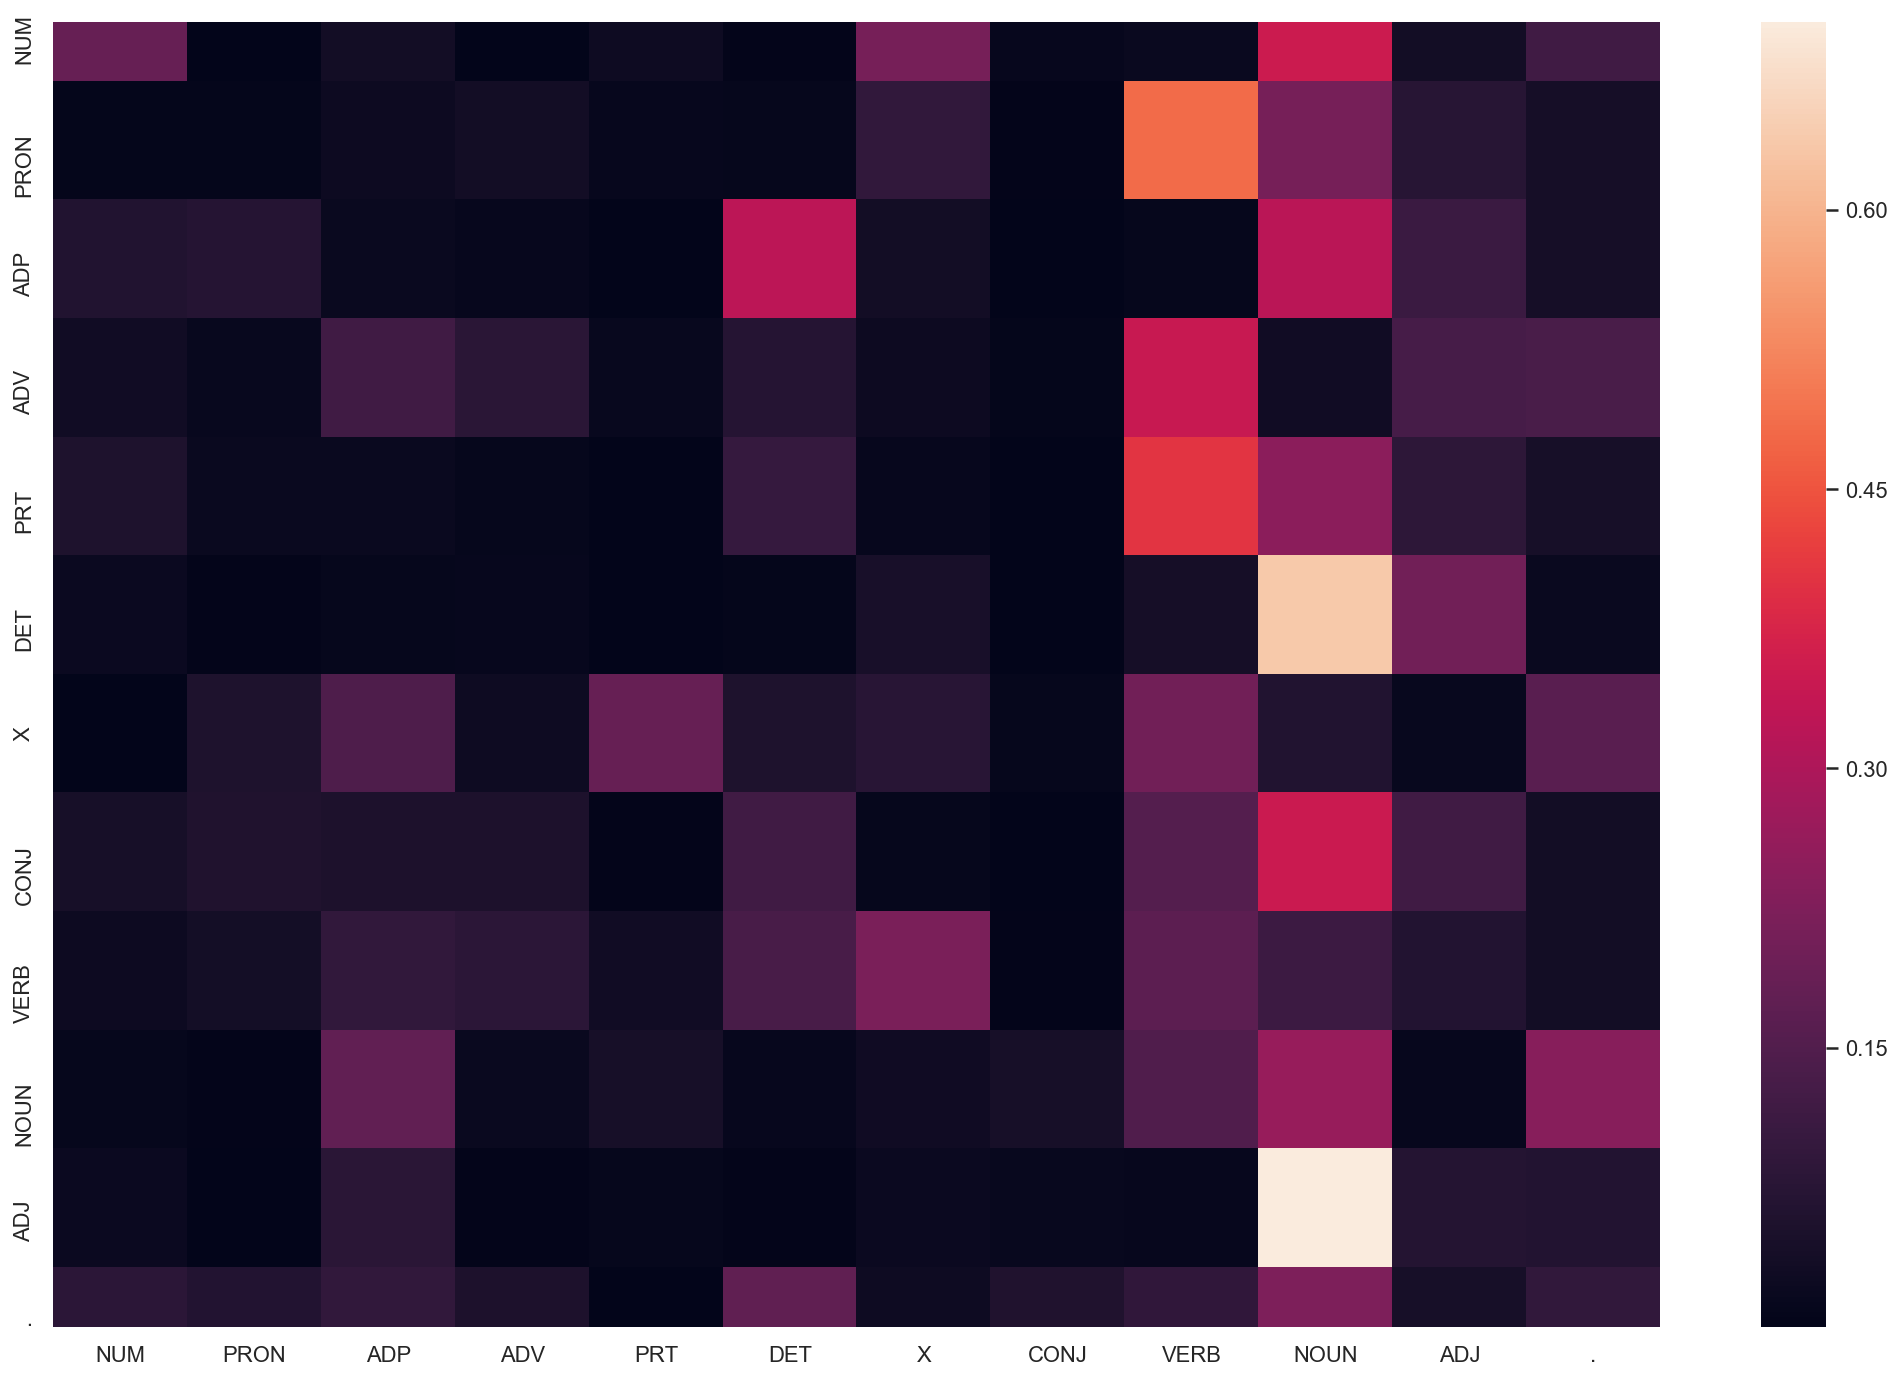

In [79]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


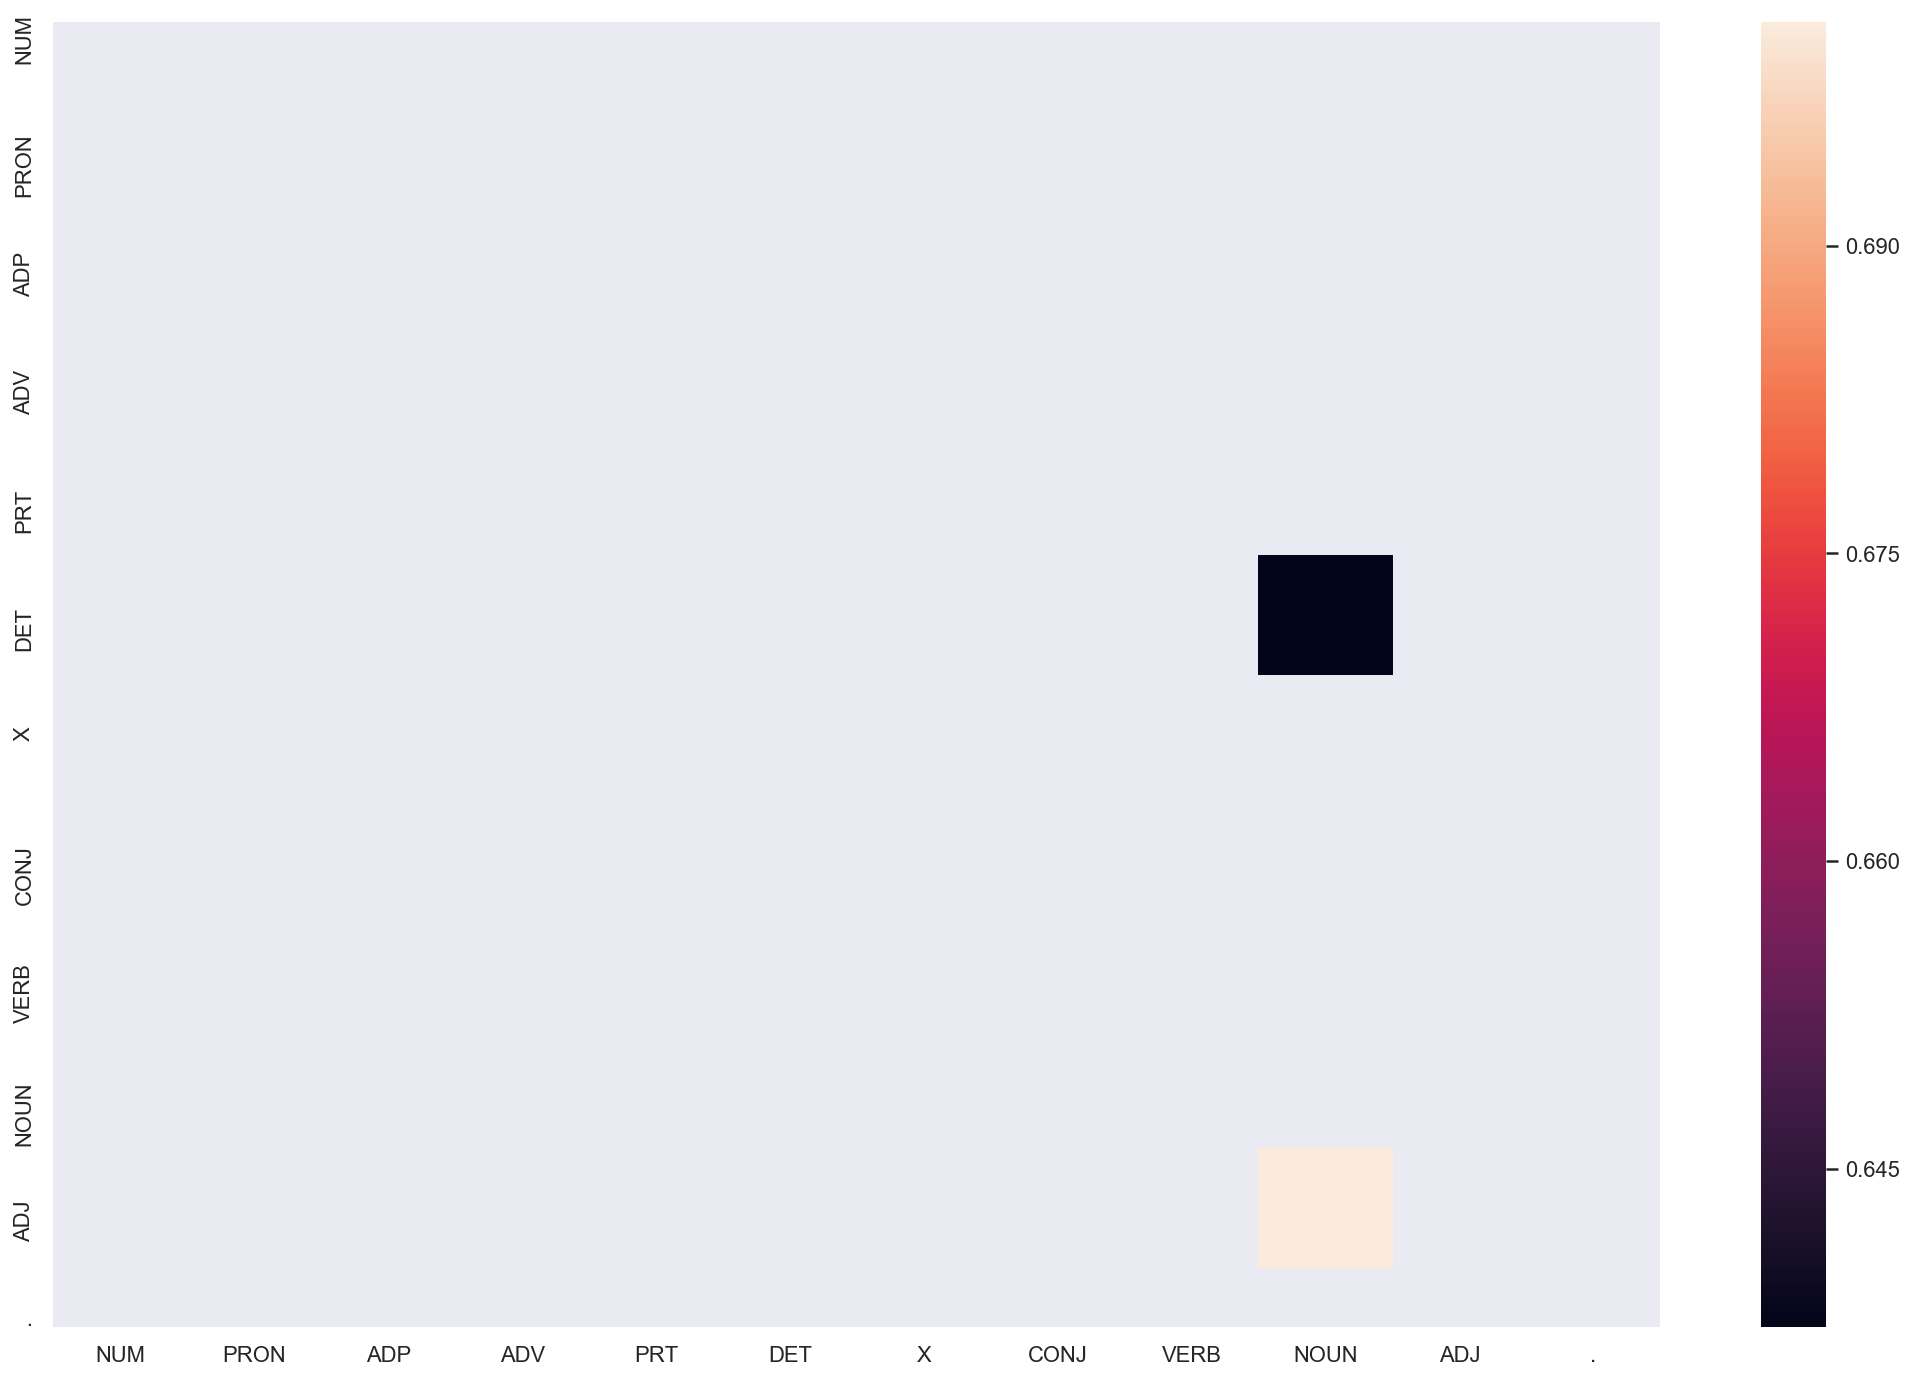

In [80]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df > 0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [81]:
def run_and_get_accuracies(tagger, sample=small_sample):
    # list of sents
    # list of tagged words
    if sample:
        random.seed(random_state)
        rndom = [random.randint(1, len(test_set)) for x in range(5)]
        test_run = [test_set[i] for i in rndom]
    else:
        test_run = test_set

    test_run_base = [tup for sent in test_run for tup in sent]
    # list of untagged words
    test_tagged_words = [tup[0] for sent in test_run for tup in sent]

    print("Sample Sentences \n")
    pprint.pprint(test_run[:4])
    start = time.time()
    tagged_seq = tagger(test_tagged_words)
    end = time.time()
    difference = end - start
    print("\nTime taken in (seconds): ", difference)
    check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
    accuracy = len(check) / len(tagged_seq)
    print("\naccuracy: ", accuracy)

    incorrect_tagged_cases = [
        j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]
    ]

    print("\nIncorrect tagged \n")
    pprint.pprint(incorrect_tagged_cases[:5])
    metrics_dict = {
        'tagger': tagger.__name__,
        'accuracy': accuracy * 100,
        'incorrect_tagged': len(incorrect_tagged_cases)
    }
    records = []
    records.append(metrics_dict)
    return pd.DataFrame.from_records(records)

### Build the vanilla Viterbi based POS tagger

In [82]:
# Viterbi Heuristic
def viterbi_vanilla(words, train_bag=train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))

    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(
                words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [83]:
tagger_metrics = run_and_get_accuracies(viterbi_vanilla)
tagger_metrics

Sample Sentences 

[[('Most', 'ADJ'),
  ('in', 'ADP'),
  ('demand', 'NOUN'),
  (':', '.'),
  ('classic', 'ADJ'),
  ('photographs', 'NOUN'),
  ('by', 'ADP'),
  ('masters', 'NOUN'),
  ('such', 'ADJ'),
  ('as', 'ADP'),
  ('Stieglitz', 'NOUN'),
  ('and', 'CONJ'),
  ('Man', 'NOUN'),
  ('Ray', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('What', 'PRON'),
  ('*T*-14', 'X'),
  ('matters', 'VERB'),
  ('is', 'VERB'),
  ('what', 'PRON'),
  ('advertisers', 'NOUN'),
  ('are', 'VERB'),
  ('paying', 'VERB'),
  ('*T*-15', 'X'),
  ('per', 'ADP'),
  ('page', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('in', 'ADP'),
  ('that', 'DET'),
  ('department', 'NOUN'),
  ('we', 'PRON'),
  ('are', 'VERB'),
  ('doing', 'VERB'),
  ('fine', 'ADV'),
  ('this', 'DET'),
  ('fall', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('said', 'VERB'),
  ('*T*-1', 'X'),
  ('Mr.', 'NOUN'),
  ('Spoon', 'NOUN'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('the', 'DET'),
  ('Army', 'NOUN'),
  ('Corps', 'NOUN'),
  ('of', 'ADP'),
  ('Engineers', 'NO

,tagger,accuracy,incorrect_tagged
0,viterbi_vanilla,94.2857,6


### Solve the problem of unknown words

We will be following the approaches mentioned in the paper https://cl.lingfil.uu.se/~nivre/statmet/haulrich.pdf

In [84]:
from collections import Counter

tags_with_frequency = Counter([pair[1] for pair in train_tagged_words])
tags_count = sum(tags_with_frequency.values())
print('Total tags: ', tags_count)

for k in tags_with_frequency.keys():
    tags_with_frequency[k] = tags_with_frequency[k] / tags_count

tags_with_frequency

Total tags:  95949


Counter({'NUM': 0.035081136853953664,
         'ADJ': 0.06362755213707282,
         'NOUN': 0.2870170611470677,
         'VERB': 0.13464444652888513,
         'ADP': 0.09831264525946075,
         'DET': 0.08669188839904532,
         'ADV': 0.03130829920061699,
         '.': 0.11619714640069204,
         'X': 0.06567030401567499,
         'PRON': 0.027201951036488134,
         'PRT': 0.03176687615295626,
         'CONJ': 0.022480692868086172})

### Most probable POS-tag
Looking at the whole training corpus we can find the most frequent POS-tagand assume that unknown words always have this POS-tag. This implies that for all unknown words we will select the tag with highest frequency in the corpus.

In [85]:
def viterbi_modified_most_probable_pos_tag(words,
                                           train_bag=train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    unknown_words = []
    tag_with_max_frequency = max(tags_with_frequency,
                                 key=tags_with_frequency.get)
    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(
                words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)

        pmax = max(p)
        if pmax == 0:
            state_max = tag_with_max_frequency
            unknown_words.append({"word": word, "mapped_to": state_max})
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        state.append(state_max)
    print("\nUnknown words:")
    display(pd.DataFrame.from_records(unknown_words))
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [86]:
df = run_and_get_accuracies(viterbi_modified_most_probable_pos_tag)
tagger_metrics = pd.concat([tagger_metrics,df],axis=0)
df

Sample Sentences 

[[('Most', 'ADJ'),
  ('in', 'ADP'),
  ('demand', 'NOUN'),
  (':', '.'),
  ('classic', 'ADJ'),
  ('photographs', 'NOUN'),
  ('by', 'ADP'),
  ('masters', 'NOUN'),
  ('such', 'ADJ'),
  ('as', 'ADP'),
  ('Stieglitz', 'NOUN'),
  ('and', 'CONJ'),
  ('Man', 'NOUN'),
  ('Ray', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('What', 'PRON'),
  ('*T*-14', 'X'),
  ('matters', 'VERB'),
  ('is', 'VERB'),
  ('what', 'PRON'),
  ('advertisers', 'NOUN'),
  ('are', 'VERB'),
  ('paying', 'VERB'),
  ('*T*-15', 'X'),
  ('per', 'ADP'),
  ('page', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('in', 'ADP'),
  ('that', 'DET'),
  ('department', 'NOUN'),
  ('we', 'PRON'),
  ('are', 'VERB'),
  ('doing', 'VERB'),
  ('fine', 'ADV'),
  ('this', 'DET'),
  ('fall', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('said', 'VERB'),
  ('*T*-1', 'X'),
  ('Mr.', 'NOUN'),
  ('Spoon', 'NOUN'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('the', 'DET'),
  ('Army', 'NOUN'),
  ('Corps', 'NOUN'),
  ('of', 'ADP'),
  ('Engineers', 'NO

,word,mapped_to
0,masters,NOUN
1,yen-support,NOUN
2,intervention,NOUN
3,150.00,NOUN
4,Iran-Contra,NOUN



Time taken in (seconds):  18.309807062149048

accuracy:  0.9619047619047619

Incorrect tagged 

[(('matters', 'NOUN'), ('matters', 'VERB')),
 (('fine', 'NOUN'), ('fine', 'ADV')),
 (('yen-support', 'NOUN'), ('yen-support', 'ADJ')),
 (('150.00', 'NOUN'), ('150.00', 'NUM'))]


,tagger,accuracy,incorrect_tagged
0,viterbi_modified_most_probable_pos_tag,96.1905,4


## Overall POS distribution

Here we give weight to probabilities of each tag. 

In [87]:
def viterbi_modified_overall_pos_distribution(words,
                                              train_bag=train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    unknown_words = []
    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = []
        p_trans = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(
                words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
            p_trans.append(tags_with_frequency.get(tag) * transition_p)

        pmax = max(p)
        if pmax == 0:
            pmax = max(p_trans)
            state_max = T[p_trans.index(pmax)]
            unknown_words.append({
                "word": word,
                "mapped_to": state_max
            })
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]

        state.append(state_max)
    print("\nUnknown words:")
    display(pd.DataFrame.from_records(unknown_words))
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [88]:
df = run_and_get_accuracies(viterbi_modified_overall_pos_distribution)
tagger_metrics = pd.concat([tagger_metrics,df],axis=0)
df

Sample Sentences 

[[('Most', 'ADJ'),
  ('in', 'ADP'),
  ('demand', 'NOUN'),
  (':', '.'),
  ('classic', 'ADJ'),
  ('photographs', 'NOUN'),
  ('by', 'ADP'),
  ('masters', 'NOUN'),
  ('such', 'ADJ'),
  ('as', 'ADP'),
  ('Stieglitz', 'NOUN'),
  ('and', 'CONJ'),
  ('Man', 'NOUN'),
  ('Ray', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('What', 'PRON'),
  ('*T*-14', 'X'),
  ('matters', 'VERB'),
  ('is', 'VERB'),
  ('what', 'PRON'),
  ('advertisers', 'NOUN'),
  ('are', 'VERB'),
  ('paying', 'VERB'),
  ('*T*-15', 'X'),
  ('per', 'ADP'),
  ('page', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('in', 'ADP'),
  ('that', 'DET'),
  ('department', 'NOUN'),
  ('we', 'PRON'),
  ('are', 'VERB'),
  ('doing', 'VERB'),
  ('fine', 'ADV'),
  ('this', 'DET'),
  ('fall', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('said', 'VERB'),
  ('*T*-1', 'X'),
  ('Mr.', 'NOUN'),
  ('Spoon', 'NOUN'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('the', 'DET'),
  ('Army', 'NOUN'),
  ('Corps', 'NOUN'),
  ('of', 'ADP'),
  ('Engineers', 'NO

,word,mapped_to
0,masters,NOUN
1,yen-support,NOUN
2,intervention,NOUN
3,150.00,NOUN
4,Iran-Contra,NOUN



Time taken in (seconds):  18.34359312057495

accuracy:  0.9619047619047619

Incorrect tagged 

[(('matters', 'NOUN'), ('matters', 'VERB')),
 (('fine', 'NOUN'), ('fine', 'ADV')),
 (('yen-support', 'NOUN'), ('yen-support', 'ADJ')),
 (('150.00', 'NOUN'), ('150.00', 'NUM'))]


,tagger,accuracy,incorrect_tagged
0,viterbi_modified_overall_pos_distribution,96.1905,4


## Regex Based Tagger

Here we will use regex based tagger as the fall back to identify the tags of the unknown words.

In [89]:
# From https://www.nltk.org/book/ch05.html

patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb 
    (r'.*able$', 'ADJ'),               # adjective 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
    (r'.*est$', 'ADJ'),
    (r'.*lly$', 'ADV'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ould$', 'X'),                # modals
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                 # nouns
]
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [90]:
def viterbi_modified_regex(words, train_bag=train_tagged_words,verbose = True):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    unknown_words = []

    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(
                words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)

        pmax = max(p)
        if pmax == 0:
            state_max = rule_based_tagger.tag([word])[0][1]
            unknown_words.append({
                "word": word,
                "mapped_to": state_max
            })
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        state.append(state_max)
    if verbose:
        print("\nUnknown words:")
        display(pd.DataFrame.from_records(unknown_words))
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [91]:
df = run_and_get_accuracies(viterbi_modified_regex)
tagger_metrics = pd.concat([tagger_metrics,df],axis=0)
df

Sample Sentences 

[[('Most', 'ADJ'),
  ('in', 'ADP'),
  ('demand', 'NOUN'),
  (':', '.'),
  ('classic', 'ADJ'),
  ('photographs', 'NOUN'),
  ('by', 'ADP'),
  ('masters', 'NOUN'),
  ('such', 'ADJ'),
  ('as', 'ADP'),
  ('Stieglitz', 'NOUN'),
  ('and', 'CONJ'),
  ('Man', 'NOUN'),
  ('Ray', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('What', 'PRON'),
  ('*T*-14', 'X'),
  ('matters', 'VERB'),
  ('is', 'VERB'),
  ('what', 'PRON'),
  ('advertisers', 'NOUN'),
  ('are', 'VERB'),
  ('paying', 'VERB'),
  ('*T*-15', 'X'),
  ('per', 'ADP'),
  ('page', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('in', 'ADP'),
  ('that', 'DET'),
  ('department', 'NOUN'),
  ('we', 'PRON'),
  ('are', 'VERB'),
  ('doing', 'VERB'),
  ('fine', 'ADV'),
  ('this', 'DET'),
  ('fall', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('said', 'VERB'),
  ('*T*-1', 'X'),
  ('Mr.', 'NOUN'),
  ('Spoon', 'NOUN'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('the', 'DET'),
  ('Army', 'NOUN'),
  ('Corps', 'NOUN'),
  ('of', 'ADP'),
  ('Engineers', 'NO

,word,mapped_to
0,masters,NOUN
1,yen-support,NOUN
2,intervention,NOUN
3,150.00,NUM
4,Iran-Contra,NOUN



Time taken in (seconds):  18.406656980514526

accuracy:  0.9714285714285714

Incorrect tagged 

[(('matters', 'NOUN'), ('matters', 'VERB')),
 (('fine', 'NOUN'), ('fine', 'ADV')),
 (('yen-support', 'NOUN'), ('yen-support', 'ADJ'))]


,tagger,accuracy,incorrect_tagged
0,viterbi_modified_regex,97.1429,3


## Mapping words to pseudo words

Here we are following the approach suggested in the paper http://www.cs.columbia.edu/~mcollins/hmms-spring2013.pdf. We will map the words to a class of pseudo words so that the unknown words can also be mapped to these pseudo words and then we will use the probability distribution for these pseudo words to figure the tag for the unknown word.

|Word class| Example |Intuition|
|----------|---------|---------|
|twoDigitNum|90|Two digit year|
|fourDigitNum|1990|Four digit year|
|containsDigitAndAlpha|A8956-67|Product code|
|containsDigitAndDash|09-96|Date|
|containsDigitAndSlash|11/9/89|Date|
|containsDigitAndComma|23,000.00|Monetary amount|
|containsDigitAndPeriod|1.00|Monetary amount,percentage|
|othernum|456789|Other number|
|allCaps|BBN|Organization|
|capPeriod|M.|Person name initial|
|initCap|Sally|Capitalized word|
|lowercase|can|Uncapitalized word|
|other|,Punctuation |marks ,    all   otherwords|

In [92]:
import re
def map_pseudo_word(word):
    pseudo_word = ""
    if word.isdigit() and len(word)==2:
        pseudo_word = "twoDigitNum"
    elif word.isdigit() and len(word)==4:
        pseudo_word = "fourDigitNum"
    elif re.match("^[A-Za-z]+[0-9]+\-.*$", word):
        pseudo_word = "containsDigitAndAlpha"
    elif re.match("^[0-9]+\-[0-9]+$", word):
        pseudo_word = "containsDigitAndDash"
    elif re.match("^[0-9]+\\\[0-9]+\\\[0-9]+$", word) or re.match("^[0-9]+/[0-9]+/[0-9]+$", word):
        pseudo_word = "containsDigitAndSlash"
    elif re.match("^[+-]?[0-9]+,[0-9]+.*$", word):
        pseudo_word = "containsDigitAndComma"
    elif re.match("^[+-]?[0-9]+\.[0-9]+$", word):
        pseudo_word = "containsDigitAndPeriod"
    elif re.match("^[0-9]+$", word):
        pseudo_word = "othernum"
    elif re.match("^[A-Z]+$", word):
        pseudo_word = "allCaps"
    elif re.match("^[A-Z]+\.$", word):
        pseudo_word = "capPeriod"
    elif word.istitle():
        pseudo_word = "initCap"
    elif re.match("^[a-z]+$", word):
        pseudo_word = "lowercase"
    else:
        pseudo_word = "other"
    return pseudo_word


In [93]:
from collections import Counter
from collections import defaultdict
pseudo_words_with_tags = [(map_pseudo_word(pair[0]), pair[1])
                          for pair in train_tagged_words]
dd = defaultdict(list)
for t in pseudo_words_with_tags:
    dd[t[0]].append(t[1])

for k in dd.keys():
    d = Counter(dd[k])
    tags_count = sum(d.values())
    for tk in d.keys():
        d[tk] = d[tk] / tags_count
    dd[k] = d

pprint.pprint(dd)

defaultdict(<class 'list'>,
            {'allCaps': Counter({'NOUN': 0.6415384615384615,
                                 'PRON': 0.16307692307692306,
                                 'DET': 0.15692307692307692,
                                 'VERB': 0.015384615384615385,
                                 'ADJ': 0.007692307692307693,
                                 'NUM': 0.006153846153846154,
                                 'ADP': 0.004615384615384616,
                                 'ADV': 0.0015384615384615385,
                                 'X': 0.0015384615384615385,
                                 'PRT': 0.0015384615384615385}),
             'capPeriod': Counter({'NOUN': 1.0}),
             'containsDigitAndComma': Counter({'NUM': 0.9900990099009901,
                                               'ADJ': 0.009900990099009901}),
             'containsDigitAndDash': Counter({'NUM': 1.0}),
             'containsDigitAndPeriod': Counter({'NUM': 1.0}),
             'fourDigitNum

In [94]:
def viterbi_modified_pseudo_mapped_words(words, train_bag=train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    unknown_words = []
    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = []
        p_trans = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(
                words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
            p_trans.append(dd.get(map_pseudo_word(
                word)).get(tag, 0) * transition_p)

        pmax = max(p)
        if pmax == 0:
            pmax = max(p_trans)
            state_max = T[p_trans.index(pmax)]
            unknown_words.append({
                "word": word,
                "mapped_to": state_max
            })
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)]
        state.append(state_max)
    print("\nUnknown words:")
    display(pd.DataFrame.from_records(unknown_words))
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [95]:
df = run_and_get_accuracies(viterbi_modified_pseudo_mapped_words)
tagger_metrics = pd.concat([tagger_metrics,df],axis=0)
df

Sample Sentences 

[[('Most', 'ADJ'),
  ('in', 'ADP'),
  ('demand', 'NOUN'),
  (':', '.'),
  ('classic', 'ADJ'),
  ('photographs', 'NOUN'),
  ('by', 'ADP'),
  ('masters', 'NOUN'),
  ('such', 'ADJ'),
  ('as', 'ADP'),
  ('Stieglitz', 'NOUN'),
  ('and', 'CONJ'),
  ('Man', 'NOUN'),
  ('Ray', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('What', 'PRON'),
  ('*T*-14', 'X'),
  ('matters', 'VERB'),
  ('is', 'VERB'),
  ('what', 'PRON'),
  ('advertisers', 'NOUN'),
  ('are', 'VERB'),
  ('paying', 'VERB'),
  ('*T*-15', 'X'),
  ('per', 'ADP'),
  ('page', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('in', 'ADP'),
  ('that', 'DET'),
  ('department', 'NOUN'),
  ('we', 'PRON'),
  ('are', 'VERB'),
  ('doing', 'VERB'),
  ('fine', 'ADV'),
  ('this', 'DET'),
  ('fall', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('said', 'VERB'),
  ('*T*-1', 'X'),
  ('Mr.', 'NOUN'),
  ('Spoon', 'NOUN'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('the', 'DET'),
  ('Army', 'NOUN'),
  ('Corps', 'NOUN'),
  ('of', 'ADP'),
  ('Engineers', 'NO

,word,mapped_to
0,masters,NOUN
1,yen-support,.
2,intervention,NOUN
3,150.00,NUM
4,Iran-Contra,NOUN



Time taken in (seconds):  18.5589120388031

accuracy:  0.9714285714285714

Incorrect tagged 

[(('matters', 'NOUN'), ('matters', 'VERB')),
 (('fine', 'NOUN'), ('fine', 'ADV')),
 (('yen-support', '.'), ('yen-support', 'ADJ'))]


,tagger,accuracy,incorrect_tagged
0,viterbi_modified_pseudo_mapped_words,97.1429,3


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [96]:
tagger_metrics = tagger_metrics.sort_values(by='accuracy', ascending=False)
tagger_metrics


,tagger,accuracy,incorrect_tagged
0,viterbi_modified_regex,97.1429,3
0,viterbi_modified_pseudo_mapped_words,97.1429,3
0,viterbi_modified_most_probable_pos_tag,96.1905,4
0,viterbi_modified_overall_pos_distribution,96.1905,4
0,viterbi_vanilla,94.2857,6


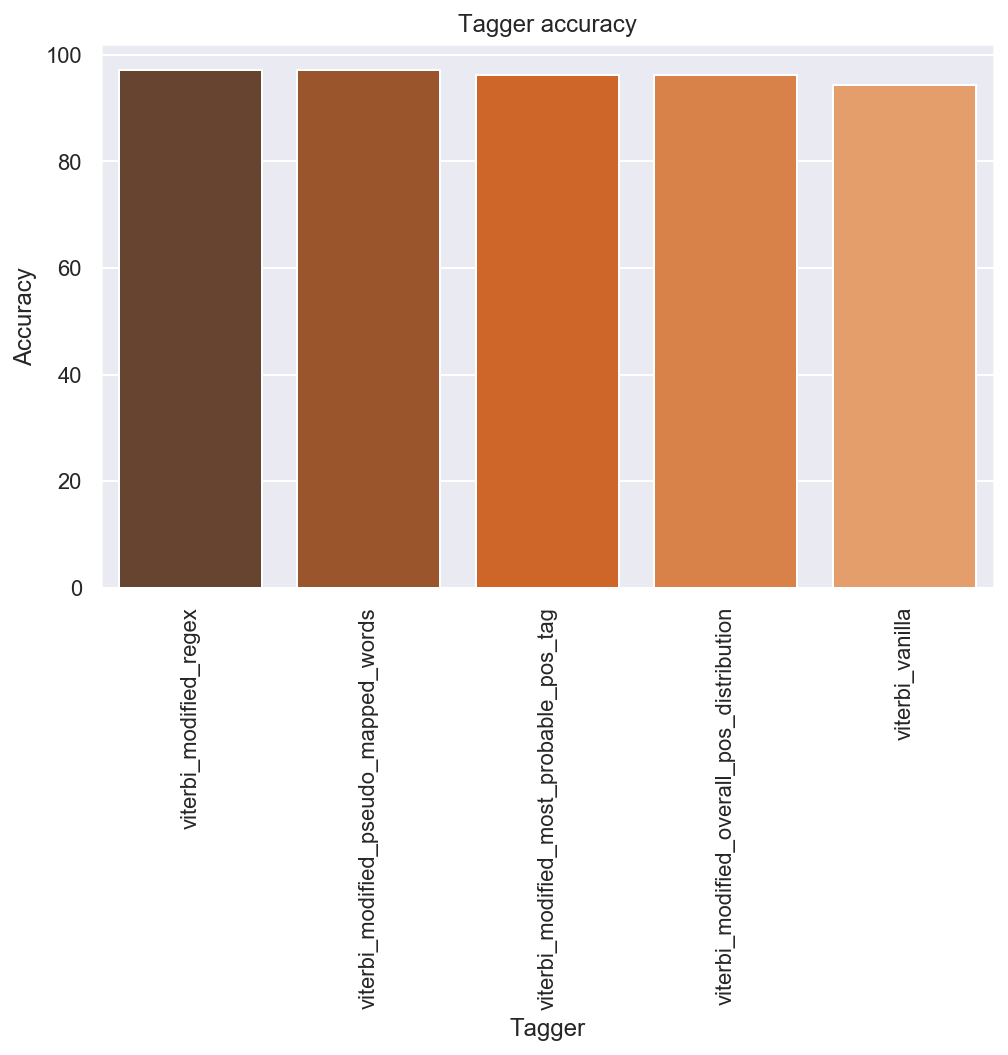

In [97]:
sns.set(rc={'figure.figsize': (8, 5)})
sns.barplot(tagger_metrics['tagger'],
            tagger_metrics['accuracy'],
            palette='Oranges_d')
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("Tagger accuracy")
plt.xlabel("Tagger")
plt.ylabel("Accuracy")
plt.show()

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [98]:
def compare_tagger(sentence, tagger1 = viterbi_vanilla, tagger2=viterbi_modified_regex):
    words = word_tokenize(sentence)
    tagger1_result = tagger1(words)
    tagger2_result = tagger2(words,verbose = False)
    
    difference = [{
        'word':i[0],
        'viterbi_vanilla':i[1],
        'viterbi_modified_regex':j[1]
    } for i, j in zip(tagger1_result, tagger2_result) if i != j]
    return pd.DataFrame.from_records(difference)    

In [99]:
sentences = [
    "Android is a mobile operating system developed by Google.",
    "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
    "The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
    "NASA invited social media users to experience the launch of ICESAT-2 Satellite."
]

In [100]:
for sentence in sentences:
    print("\nFor sentence: ",sentence)
    display(compare_tagger(sentence))


For sentence:  Android is a mobile operating system developed by Google.


,word,viterbi_vanilla,viterbi_modified_regex
0,Android,NUM,NOUN
1,Google,NUM,NOUN



For sentence:  Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.


,word,viterbi_vanilla,viterbi_modified_regex
0,Google,NUM,NOUN
1,Twitter,NUM,NOUN
2,Google,NUM,NOUN
3,Twitter,NUM,NOUN
4,firehose,NUM,NOUN



For sentence:  The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.


,word,viterbi_vanilla,viterbi_modified_regex
0,FIFA,NUM,NOUN
1,Cup,NUM,NOUN
2,21st,NUM,NOUN
3,FIFA,NUM,NOUN
4,Cup,NUM,NOUN
5,tournament,NUM,NOUN
6,contested,NUM,VERB



For sentence:  NASA invited social media users to experience the launch of ICESAT-2 Satellite.


,word,viterbi_vanilla,viterbi_modified_regex
0,NASA,NUM,NOUN
1,invited,NUM,VERB
2,ICESAT-2,NUM,NOUN
3,Satellite,NUM,NOUN


We can see that words like `Android`, `Google`, `Twitter`, `FIFA`, `contested` etc which were incorrectly tagged by the vanilla Viterbi tagger as `NUM` are correctly tagged by the modified regex tagger.